In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [83]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### 1. Data Preparation

In [84]:
dataset = pd.read_csv('data/Auto_MPG_data.csv')
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [85]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Europe        392 non-null    int64  
 8   Japan         392 non-null    int64  
 9   USA           392 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 30.8 KB


#### 2. Data Preprocessing

In [86]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [87]:
#  Split data train/val/test
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [88]:
# Input Normalization
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.fit_transform(X_val)
X_test = normalizer.fit_transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

#### 3. DataLoader

In [89]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [90]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False)

#### 4. Build MLPs Model

In [91]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = self.output(x)
        return output.squeeze(1)

In [92]:
input_dim = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dim, 
            hidden_dims, 
            output_dims).to(device)

#### 5. Initialize loss and optimizer

In [93]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

#### 6. Build R2-Score function

In [94]:
def r_squared(y_true, y_pred):
    y_true = torch.tensor(y_true).to(device)
    y_pred = torch.tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_total = torch.sum((y_true - mean_true) ** 2)
    ss_residual = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

#### 7. Training model

In [95]:
epochs = 100
# def train_model(model):
#     train_losses = []
#     val_losses = []
#     train_r2 = []
#     val_r2 = []
#     for epoch in range(epochs):
#         train_loss = 0.0
#         val_loss = 0.0
#         train_target = []
#         val_target = []
#         train_pred = []
#         val_pred = []
#         model.train()
#         for X_samples, y_samples in train_loader:
#             X_samples = X_samples.to(device)
#             y_samples = y_samples.to(device)

#             optimizer.zero_grad()
#             y_pred = model(X_samples)

#             train_pred += y_pred.tolist()
#             train_target += y_samples.tolist()

#             loss = criterion(y_pred, y_samples)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
        
#         train_loss /= len(train_loader)
#         train_losses.append(train_loss)
#         train_r2.append(r_squared(train_target, train_pred))
        
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for X_samples, y_samples in val_loader:
#                 X_samples = X_samples.to(device)
#                 y_samples = y_samples.to(device)
                
#                 y_pred = model(X_samples)
#                 val_pred += y_pred.tolist()
#                 val_target += y_samples.tolist()
#                 loss = criterion(y_pred, y_samples)
#                 val_loss += loss.item()
        
#         val_loss /= len(val_loader)
#         val_losses.append(val_loss)
#         val_r2.append(r_squared(val_target, val_pred))
        
#         print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

#     # Final R2 on test set
#     model.eval()
#     with torch.no_grad():
#         y_hat = model(X_test.to(device))
#         test_set_r2 = r_squared(y_test.tolist(), y_hat.tolist())
#         print(f'Final R2 on test set: {test_set_r2:.4f}')

#     return train_losses, val_losses, train_r2, val_r2


In [96]:
# train_losses, val_losses, train_r2, val_r2 = train_model(model)

In [97]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            
            loss = criterion(outputs, y_samples)
            
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 282.770	Validation loss: 75.781

EPOCH 2:	Training loss: 137.627	Validation loss: 64.587

EPOCH 3:	Training loss: 71.299	Validation loss: 23.249

EPOCH 4:	Training loss: 24.021	Validation loss: 159.939

EPOCH 5:	Training loss: 99.607	Validation loss: 30.917

EPOCH 6:	Training loss: 17.785	Validation loss: 6.602

EPOCH 7:	Training loss: 15.954	Validation loss: 13.936

EPOCH 8:	Training loss: 36.122	Validation loss: 34.403

EPOCH 9:	Training loss: 16.440	Validation loss: 34.291

EPOCH 10:	Training loss: 21.854	Validation loss: 49.926



EPOCH 11:	Training loss: 30.077	Validation loss: 21.193

EPOCH 12:	Training loss: 9.934	Validation loss: 6.172

EPOCH 13:	Training loss: 16.008	Validation loss: 13.150

EPOCH 14:	Training loss: 11.469	Validation loss: 13.142

EPOCH 15:	Training loss: 14.523	Validation loss: 8.954

EPOCH 16:	Training loss: 10.114	Validation loss: 16.096

EPOCH 17:	Training loss: 12.141	Validation loss: 13.527

EPOCH 18:	Training loss: 15.554	Validation loss: 11.676

EPOCH 19:	Training loss: 14.683	Validation loss: 6.052

EPOCH 20:	Training loss: 7.241	Validation loss: 5.556

EPOCH 21:	Training loss: 8.790	Validation loss: 5.390

EPOCH 22:	Training loss: 6.167	Validation loss: 6.155

EPOCH 23:	Training loss: 9.994	Validation loss: 47.224

EPOCH 24:	Training loss: 10.343	Validation loss: 15.683

EPOCH 25:	Training loss: 9.331	Validation loss: 7.879

EPOCH 26:	Training loss: 10.611	Validation loss: 7.519

EPOCH 27:	Training loss: 6.227	Validation loss: 6.612

EPOCH 28:	Training loss: 9.938	Validation loss

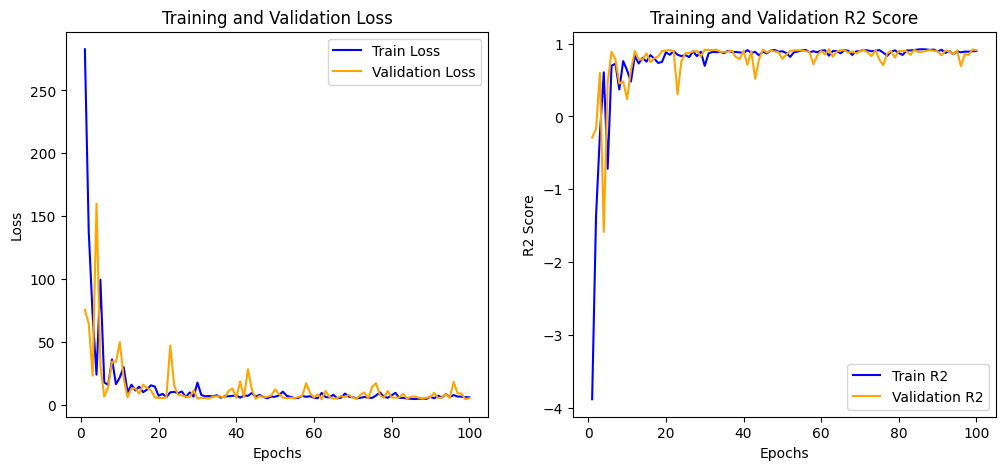

In [98]:
def plot_training_history(train_losses, val_losses, train_r2, val_r2):
    epochs = range(1, len(train_losses) + 1)
    
    # Chuyển các tensor về CPU trước khi vẽ
    train_losses = [loss.cpu() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
    val_losses = [loss.cpu() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]
    train_r2 = [r2.cpu() if isinstance(r2, torch.Tensor) else r2 for r2 in train_r2]
    val_r2 = [r2.cpu() if isinstance(r2, torch.Tensor) else r2 for r2 in val_r2]

    # Plot Loss vs Epochs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot R2 Score vs Epochs
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_r2, label='Train R2', color='blue')
    plt.plot(epochs, val_r2, label='Validation R2', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('R2 Score')
    plt.title('Training and Validation R2 Score')
    plt.legend()

    plt.show()

# Gọi hàm sau khi huấn luyện
plot_training_history(train_losses, val_losses, train_r2, val_r2)


In [ ]:
model.eval()
with torch.no_grad():
  X_test = X_test.to(device) 
  y_hat = model(X_test)
  test_set_r2 = r_squared(y_hat, y_test)
  print('Evaluation on test set:')
  print(f'R2: {test_set_r2}')

Evaluation on test set:
R2: 0.8051668405532837


C:\Users\Admin\AppData\Local\Temp\ipykernel_28736\1656472900.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true).to(device)
C:\Users\Admin\AppData\Local\Temp\ipykernel_28736\1656472900.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_pred).to(device)
